In [2]:
! rm -rf space-model
! git clone https://github.com/StepanTita/space-model.git

Cloning into 'space-model'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 155 (delta 47), reused 128 (delta 23), pack-reused 0
Receiving objects: 100% (155/155), 29.68 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [1]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer

from train import run, get_preds_from_logits, prepare_dataset

from collections import Counter

/home/stepan/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
MODEL_NAME = 'FacebookAI/roberta-base'
DATASET_NAME = 'hatespeech'

SEED = 42
NUM_EPOCHS = 15
BATCH_SIZE = 256
MAX_SEQ_LEN = 512
LEARNING_RATE = 2e-5
MAX_GRAD_NORM = 1000

In [3]:
def prepare_hateoffensive(model_name, max_seq_len, device, seed):
    # 3 classes
    dataset = load_dataset("tdavidson/hate_speech_offensive")

    # Split the training set into training (80%) and validation (20%) sets
    train_testvalid = dataset['train'].train_test_split(test_size=0.2, seed=42)
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

    # Assign datasets
    train_dataset = train_testvalid['train']
    val_dataset = test_valid['test']
    test_dataset = test_valid['train']

    dataset = DatasetDict({
        'train': train_dataset,
        'test': test_dataset,
        'val': val_dataset
    })

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized_dataset = dataset.map(
        lambda x: tokenizer(x['tweet'], truncation=True, padding='max_length', max_length=max_seq_len,
                            return_tensors='pt'),
        batched=True)
    tokenized_dataset.set_format('torch', device=device)

    return tokenized_dataset.rename_columns({'class': 'label'})

def prepare_hatexplain(model_name, max_seq_len, device, seed):
    # 3 classes
    def get_label(annotators):
        # get the most common label using simple voting and accounting for batching
        return [Counter(anno['label']).most_common(1)[0][0] for anno in annotators]
            
    dataset = load_dataset('hatexplain')
    dataset = dataset.map(lambda x: {'label': get_label(x['annotators'])}, num_proc=4, batched=True)
    dataset['val'] = dataset['validation']
    del dataset['validation']
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    tokenized_dataset = dataset.map(lambda x: tokenizer(x['post_tokens'], truncation=True, padding='max_length', max_length=max_seq_len, return_tensors='pt'), batched=True)
    tokenized_dataset.set_format('torch', device=device)
    
    return tokenized_dataset

def prepare_emotions(model_name, max_seq_len, device, seed):
    # 28 classes
    emotions_1_df = pd.read_csv(f'data/goemotions_1.csv')
    emotions_2_df = pd.read_csv(f'data/goemotions_2.csv')
    emotions_3_df = pd.read_csv(f'data/goemotions_3.csv')

    emotions_df = pd.concat([
        emotions_1_df,
        emotions_2_df,
        emotions_3_df
    ], ignore_index=True, axis=0)
    
    labels = [
        'admiration',
        'amusement',
        'anger',
        'annoyance',
        'approval',
        'caring',
        'confusion',
        'curiosity',
        'desire',
        'disappointment',
        'disapproval',
        'disgust',
        'embarrassment',
        'excitement',
        'fear',
        'gratitude',
        'grief',
        'joy',
        'love',
        'nervousness',
        'optimism',
        'pride',
        'realization',
        'relief',
        'remorse',
        'sadness',
        'surprise',
        'neutral'
    ]
    emotions_df['label'] = emotions_df[labels].apply(lambda x: x.to_list(), axis=1)
    train_split, test_split = train_test_split(emotions_df, test_size=0.2, random_state=seed)
    test_split, val_split = train_test_split(test_split, test_size=0.5, random_state=seed)
    dataset = DatasetDict({
        'train': Dataset.from_pandas(train_split[['text', 'label']]),
        'val': Dataset.from_pandas(test_split[['text', 'label']]),
        'test': Dataset.from_pandas(val_split[['text', 'label']]),
    })
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    tokenized_dataset = dataset
    tokenized_dataset = tokenized_dataset.map(
        lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN,
                            return_tensors='pt'), batched=True)
    tokenized_dataset.set_format('torch', device=device)
    return tokenized_dataset

In [4]:
def train_wrapper(device_id, train_base, train_space, experiment_name, n_latent, config):
    def train():
        run({
            'experiment_name': experiment_name,
            
            'log_terminal': True,

            'device_id': device_id,
            'train_base': train_base,
            'train_space': train_space,

            'seed': SEED,
            'dataset_name': DATASET_NAME,
            'model_name': MODEL_NAME,

            'num_labels': 3,
            'num_epochs': NUM_EPOCHS,
            'iterations': 1,

            'max_seq_len': MAX_SEQ_LEN,
            'batch_size': BATCH_SIZE,
            'lr': LEARNING_RATE,
            'fp16': False,
            'max_grad_norm': MAX_GRAD_NORM,
            'weight_decay': 0.01,
            'num_warmup_steps': 0,
            'gradient_accumulation_steps': 1,

            'n_latent': n_latent,
            'l1': config['l1'],
            'l2': config['l2'],
            'cross_entropy_weight': config['ce_w'],
            
            # funcs:
            'preds_from_logits_func': get_preds_from_logits,
            'get_data_func': prepare_hateoffensive
        })

    return train

In [5]:
latents = [2 ** i for i in range(2, 10)]
latents

[4, 8, 16, 32, 64, 128, 256, 512]

In [ ]:
for lat in latents:
    print('Latents:', lat)
    train_wrapper(device_id=1, train_base=False, train_space=True, experiment_name='latents', n_latent=lat, config={
        'l1': 0.1,
        'l2': 1e-5,
        'ce_w': 1.0,
    })()

Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 1, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'hatespeech', 'model_name': 'FacebookAI/roberta-base', 'num_labels': 3, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 256, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 16, 'l1': 0.1, 'l2': 1e-05, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x76774cd531f0>, 'get_data_func': <function prepare_hateoffensive at 0x76774cd5b5e0>}
Loading dataset...


Latents: 16


Map:   0%|          | 0/2479 [00:00<?, ? examples/s]

Training space model...
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Number of space model parameters: 37011
Inter-space loss: 25.108304977416992
Intra-space loss: 236.87310791015625
****************************** Iteration: 1 ******************************
Train steps: 1161
Steps per epoch: 77.4453125
Epoch: 1
100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.37s/it]
/home/stepan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stepan/.local/lib/python3.8/site-pac

2024-06-16 14:23:05,962 - default.terminal - INFO - Starting...
2024-06-16 14:23:05,964 - default.terminal - INFO - Config: {'experiment_name': 'inter-loss', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'distilbert-base-cased', 'num_labels': 2, 'num_epochs': 5, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 256, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 4, 'l1': 0.5, 'l2': 0.01, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x7a918879ed30>, 'get_data_func': <function prepare_dataset at 0x7a918879e940>}
2024-06-16 14:23:05,964 - default.terminal - DEBUG - Loading dataset...


Latents: 4


2024-06-16 14:23:07,620 - default.terminal - DEBUG - Training space model...
2024-06-16 14:23:07,726 - default.terminal - INFO - Number of space model parameters: 6162
2024-06-16 14:23:07,734 - default.terminal - DEBUG - Inter-space loss: 104.50141906738281
2024-06-16 14:23:07,735 - default.terminal - DEBUG - Intra-space loss: 889.997802734375
2024-06-16 14:23:07,736 - default.terminal - INFO - ****************************** Iteration: 1 ******************************
2024-06-16 14:23:07,737 - default.terminal - DEBUG - Train steps: 390
2024-06-16 14:23:07,738 - default.terminal - DEBUG - Steps per epoch: 78.125
2024-06-16 14:23:07,738 - default.terminal - INFO - Epoch: 1
100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]
/home/stepan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Initial GPU Usage
GPU memory occupied: 19485 MB.
GPU Usage after emptying the cache
GPU memory occupied: 10649 MB.


2024-06-16 14:36:19,929 - default.terminal - DEBUG - Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [02:06<00:00,  1.29s/it]
2024-06-16 14:38:26,555 - default.terminal - INFO - Val loss: 3.0864760389133377
2024-06-16 14:38:26,556 - default.terminal - INFO - Val acc: 0.49996
2024-06-16 14:38:26,556 - default.terminal - INFO - CS Val acc: 0.5
2024-06-16 14:38:26,557 - default.terminal - INFO - Val f1: 0.33338664533776957
2024-06-16 14:38:26,557 - default.terminal - INFO - CS Val f1: 0.3333333333333333
2024-06-16 14:38:26,558 - default.terminal - INFO - Val precision: 0.41665666546652264
2024-06-16 14:38:26,559 - default.terminal - INFO - Val recall: 0.49995999999999996
2024-06-16 14:38:26,570 - default.terminal - INFO - Starting...
2024-06-16 14:38:26,571 - default.terminal - INFO - Config: {'experiment_name': 'inter-loss', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'mode

Latents: 8


2024-06-16 14:38:28,208 - default.terminal - DEBUG - Training space model...
2024-06-16 14:38:28,307 - default.terminal - INFO - Number of space model parameters: 12322
2024-06-16 14:38:28,315 - default.terminal - DEBUG - Inter-space loss: 134.04527282714844
2024-06-16 14:38:28,316 - default.terminal - DEBUG - Intra-space loss: 1791.443359375
2024-06-16 14:38:28,317 - default.terminal - INFO - ****************************** Iteration: 1 ******************************
2024-06-16 14:38:28,318 - default.terminal - DEBUG - Train steps: 390
2024-06-16 14:38:28,319 - default.terminal - DEBUG - Steps per epoch: 78.125
2024-06-16 14:38:28,319 - default.terminal - INFO - Epoch: 1
100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]
2024-06-16 14:40:41,267 - default.terminal - INFO - 
2024-06-16 14:40:41,268 - default.terminal - INFO - Train loss: 9.333697530287731 | Val loss: 7.878131747245789
2024-06-16 14:40:41,268 - default.terminal - INFO - Train acc: 0.4973 | Va

Initial GPU Usage
GPU memory occupied: 19869 MB.
GPU Usage after emptying the cache
GPU memory occupied: 10649 MB.


2024-06-16 14:51:40,978 - default.terminal - DEBUG - Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [02:06<00:00,  1.29s/it]
2024-06-16 14:53:47,364 - default.terminal - INFO - Val loss: 4.964117128021863
2024-06-16 14:53:47,365 - default.terminal - INFO - Val acc: 0.49912
2024-06-16 14:53:47,366 - default.terminal - INFO - CS Val acc: 0.50388
2024-06-16 14:53:47,366 - default.terminal - INFO - Val f1: 0.33393262730120904
2024-06-16 14:53:47,367 - default.terminal - INFO - CS Val f1: 0.3451947614626399
2024-06-16 14:53:47,367 - default.terminal - INFO - Val precision: 0.3897795591182365
2024-06-16 14:53:47,368 - default.terminal - INFO - Val recall: 0.49912
2024-06-16 14:53:47,379 - default.terminal - INFO - Starting...
2024-06-16 14:53:47,380 - default.terminal - INFO - Config: {'experiment_name': 'inter-loss', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': '

Latents: 16


2024-06-16 14:53:48,422 - default.terminal - DEBUG - Training space model...
2024-06-16 14:53:48,525 - default.terminal - INFO - Number of space model parameters: 24642
2024-06-16 14:53:48,533 - default.terminal - DEBUG - Inter-space loss: 130.69830322265625
2024-06-16 14:53:48,534 - default.terminal - DEBUG - Intra-space loss: 3423.1533203125
2024-06-16 14:53:48,534 - default.terminal - INFO - ****************************** Iteration: 1 ******************************
2024-06-16 14:53:48,535 - default.terminal - DEBUG - Train steps: 390
2024-06-16 14:53:48,536 - default.terminal - DEBUG - Steps per epoch: 78.125
2024-06-16 14:53:48,537 - default.terminal - INFO - Epoch: 1
100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]
2024-06-16 14:56:01,501 - default.terminal - INFO - 
2024-06-16 14:56:01,502 - default.terminal - INFO - Train loss: 16.50804378412947 | Val loss: 13.739391326904297
2024-06-16 14:56:01,502 - default.terminal - INFO - Train acc: 0.5004 | 

Initial GPU Usage
GPU memory occupied: 19869 MB.
GPU Usage after emptying the cache
GPU memory occupied: 10649 MB.


2024-06-16 15:22:19,523 - default.terminal - DEBUG - Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [02:06<00:00,  1.29s/it]
2024-06-16 15:24:25,691 - default.terminal - INFO - Val loss: 15.210484436580114
2024-06-16 15:24:25,692 - default.terminal - INFO - Val acc: 0.50004
2024-06-16 15:24:25,693 - default.terminal - INFO - CS Val acc: 0.50372
2024-06-16 15:24:25,693 - default.terminal - INFO - Val f1: 0.334414910789584
2024-06-16 15:24:25,694 - default.terminal - INFO - CS Val f1: 0.45539592166930437
2024-06-16 15:24:25,695 - default.terminal - INFO - Val precision: 0.5086307012686441
2024-06-16 15:24:25,695 - default.terminal - INFO - Val recall: 0.50004
2024-06-16 15:24:25,706 - default.terminal - INFO - Starting...
2024-06-16 15:24:25,707 - default.terminal - INFO - Config: {'experiment_name': 'inter-loss', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': '

Latents: 64


2024-06-16 15:24:27,435 - default.terminal - DEBUG - Training space model...
2024-06-16 15:24:27,537 - default.terminal - INFO - Number of space model parameters: 98562
2024-06-16 15:24:27,545 - default.terminal - DEBUG - Inter-space loss: 128.51731872558594
2024-06-16 15:24:27,546 - default.terminal - DEBUG - Intra-space loss: 13731.7861328125
2024-06-16 15:24:27,547 - default.terminal - INFO - ****************************** Iteration: 1 ******************************
2024-06-16 15:24:27,548 - default.terminal - DEBUG - Train steps: 390
2024-06-16 15:24:27,549 - default.terminal - DEBUG - Steps per epoch: 78.125
2024-06-16 15:24:27,549 - default.terminal - INFO - Epoch: 1
100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]
/home/stepan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

Initial GPU Usage
GPU memory occupied: 19869 MB.
GPU Usage after emptying the cache
GPU memory occupied: 10647 MB.


2024-06-16 15:37:39,910 - default.terminal - DEBUG - Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [02:06<00:00,  1.29s/it]
2024-06-16 15:39:46,129 - default.terminal - INFO - Val loss: 29.807671060367507
2024-06-16 15:39:46,130 - default.terminal - INFO - Val acc: 0.49876
2024-06-16 15:39:46,131 - default.terminal - INFO - CS Val acc: 0.50272
2024-06-16 15:39:46,131 - default.terminal - INFO - Val f1: 0.3365708759296815
2024-06-16 15:39:46,132 - default.terminal - INFO - CS Val f1: 0.45339420566201305
2024-06-16 15:39:46,133 - default.terminal - INFO - Val precision: 0.4439328710797502
2024-06-16 15:39:46,133 - default.terminal - INFO - Val recall: 0.49876
2024-06-16 15:39:46,145 - default.terminal - INFO - Starting...
2024-06-16 15:39:46,145 - default.terminal - INFO - Config: {'experiment_name': 'inter-loss', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 

Latents: 128


2024-06-16 15:39:47,760 - default.terminal - DEBUG - Training space model...
2024-06-16 15:39:47,861 - default.terminal - INFO - Number of space model parameters: 197122
2024-06-16 15:39:47,869 - default.terminal - DEBUG - Inter-space loss: 126.00299072265625
2024-06-16 15:39:47,870 - default.terminal - DEBUG - Intra-space loss: 26602.75
2024-06-16 15:39:47,871 - default.terminal - INFO - ****************************** Iteration: 1 ******************************
2024-06-16 15:39:47,872 - default.terminal - DEBUG - Train steps: 390
2024-06-16 15:39:47,873 - default.terminal - DEBUG - Steps per epoch: 78.125
2024-06-16 15:39:47,873 - default.terminal - INFO - Epoch: 1
100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]
2024-06-16 15:42:01,364 - default.terminal - INFO - 
2024-06-16 15:42:01,365 - default.terminal - INFO - Train loss: 120.27963266493398 | Val loss: 98.77306175231934
2024-06-16 15:42:01,366 - default.terminal - INFO - Train acc: 0.57465 | Val a

Initial GPU Usage
GPU memory occupied: 20255 MB.
GPU Usage after emptying the cache
GPU memory occupied: 10649 MB.


2024-06-16 15:53:03,633 - default.terminal - DEBUG - Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [02:06<00:00,  1.29s/it]
2024-06-16 15:55:10,211 - default.terminal - INFO - Val loss: 57.159942821580536
2024-06-16 15:55:10,211 - default.terminal - INFO - Val acc: 0.57268
2024-06-16 15:55:10,212 - default.terminal - INFO - CS Val acc: 0.50384
2024-06-16 15:55:10,213 - default.terminal - INFO - Val f1: 0.5308742374769783
2024-06-16 15:55:10,213 - default.terminal - INFO - CS Val f1: 0.3967335023693452
2024-06-16 15:55:10,214 - default.terminal - INFO - Val precision: 0.6129372444044313
2024-06-16 15:55:10,215 - default.terminal - INFO - Val recall: 0.57268


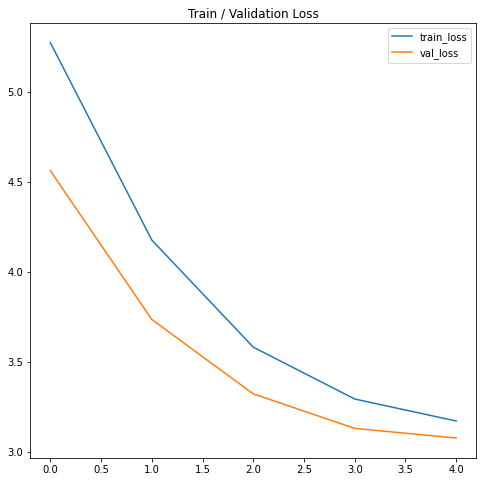

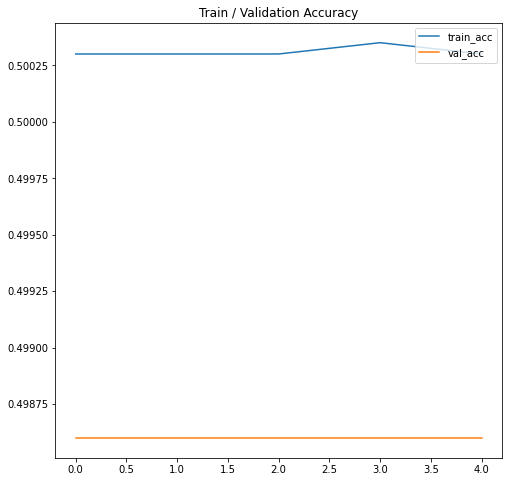

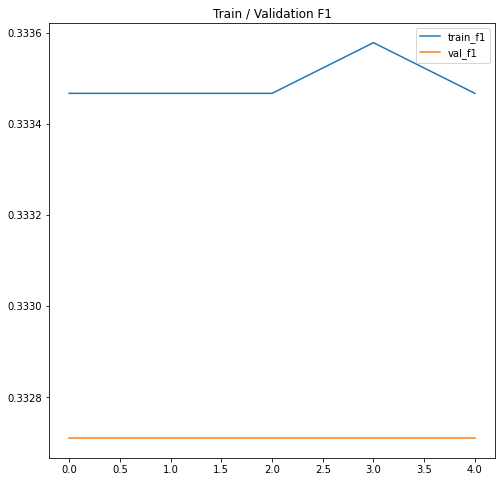

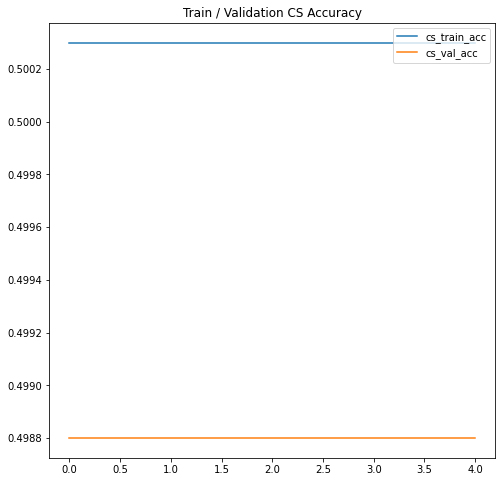

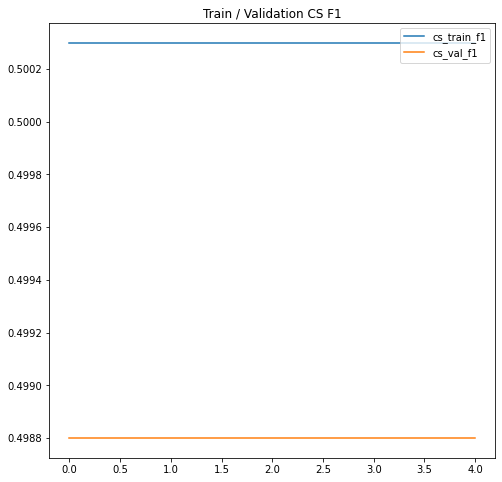

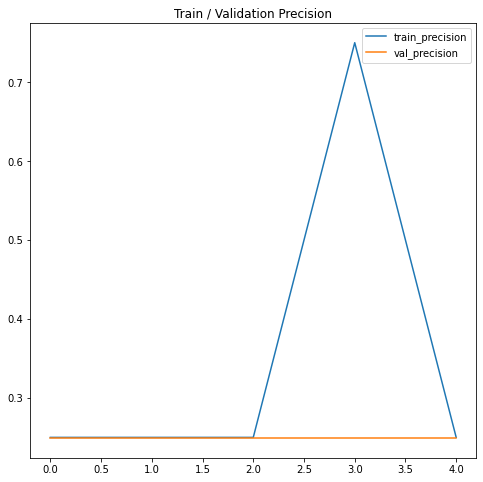

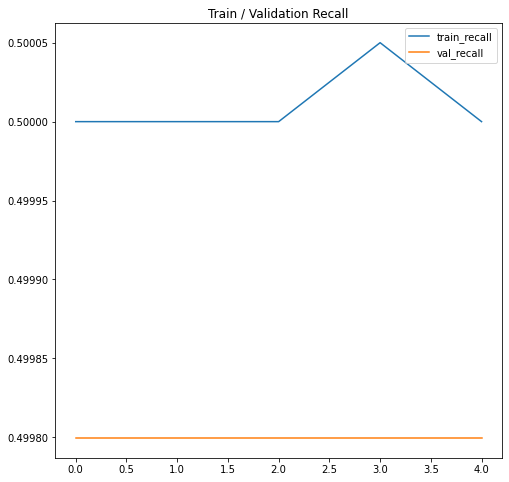

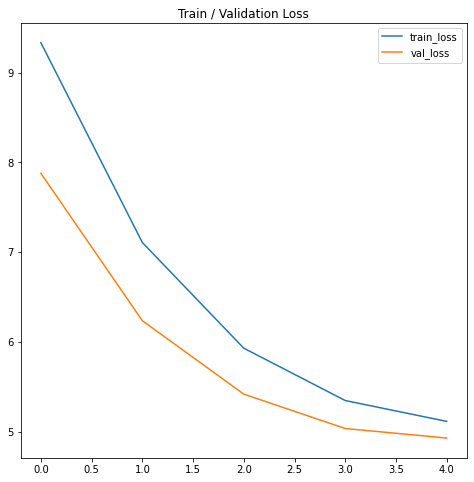

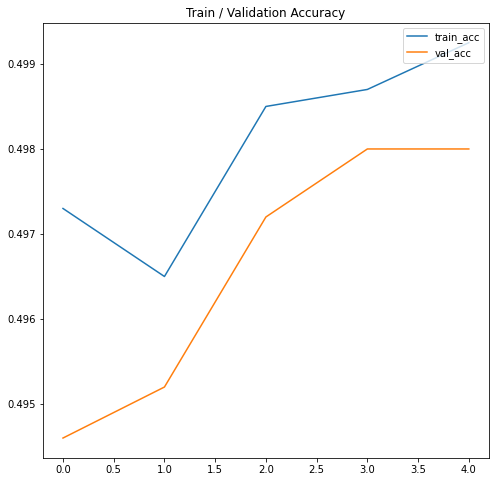

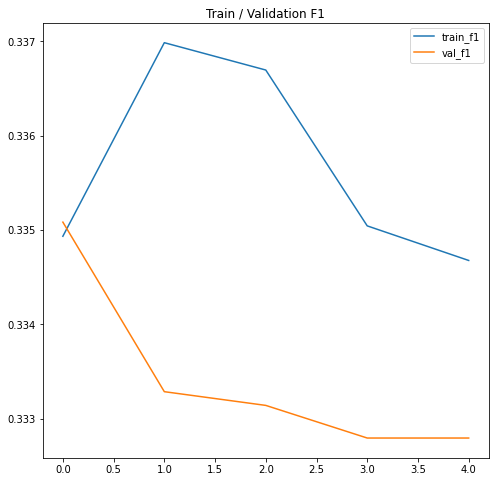

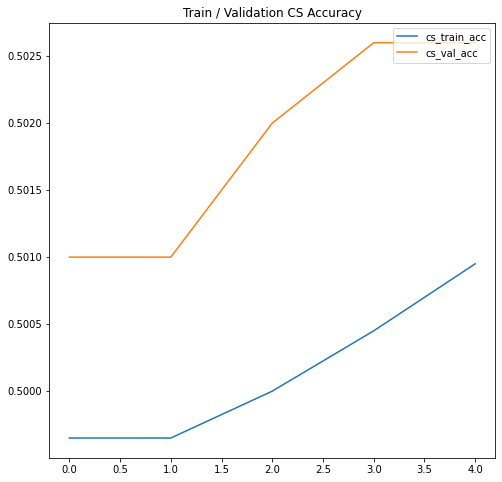

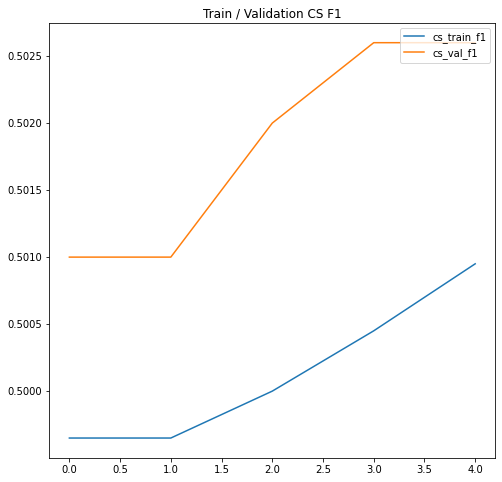

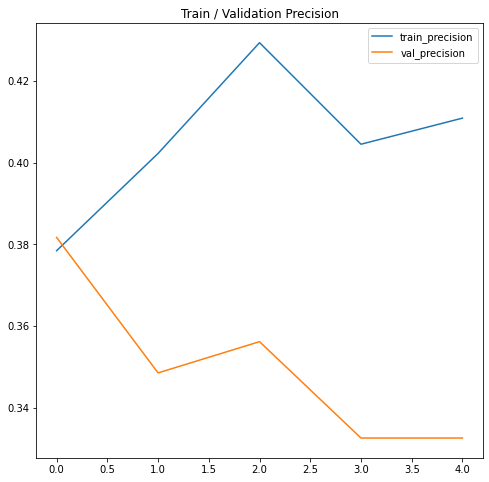

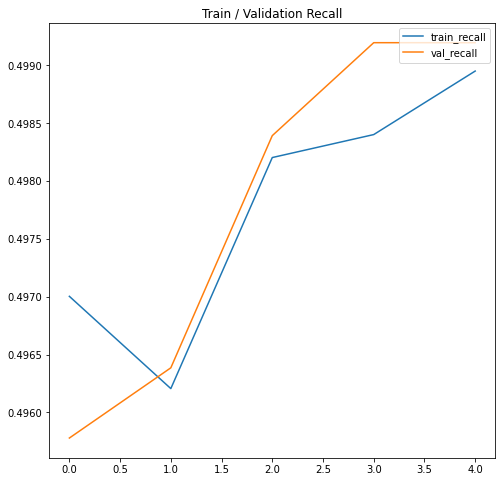

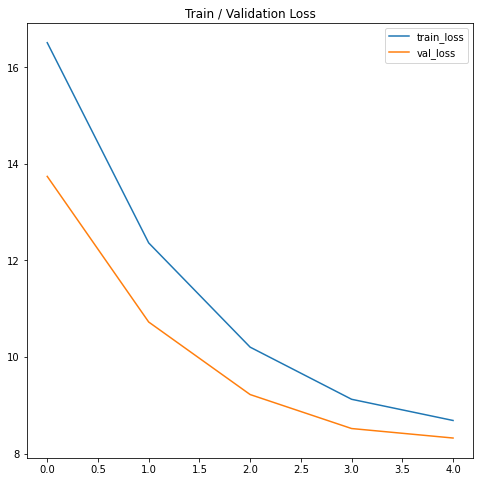

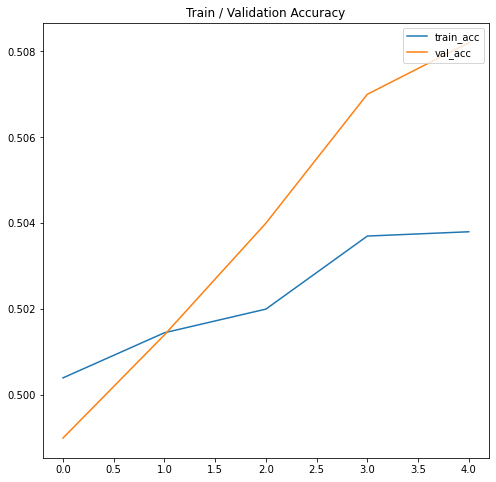

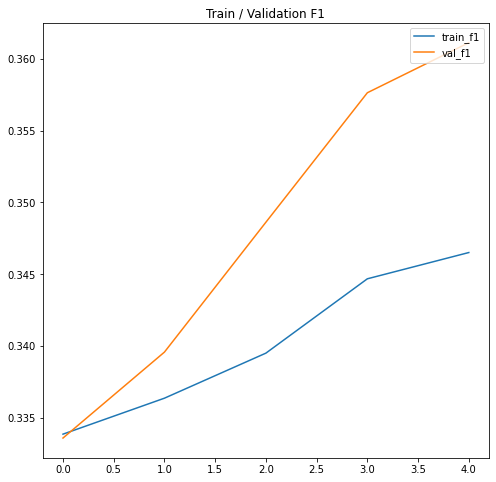

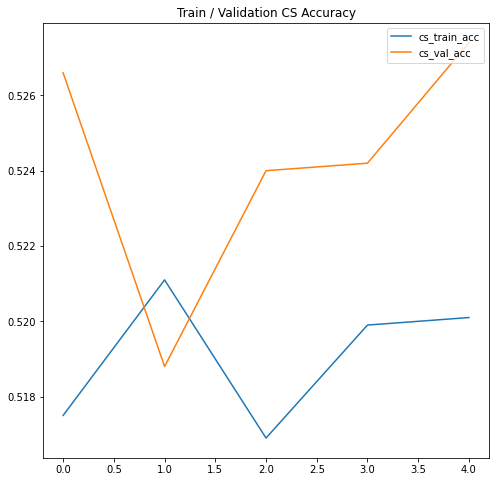

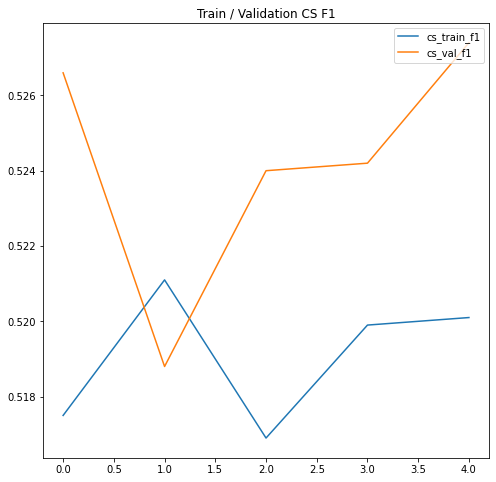

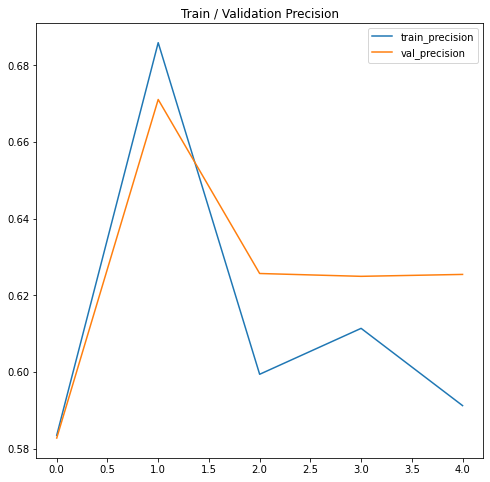

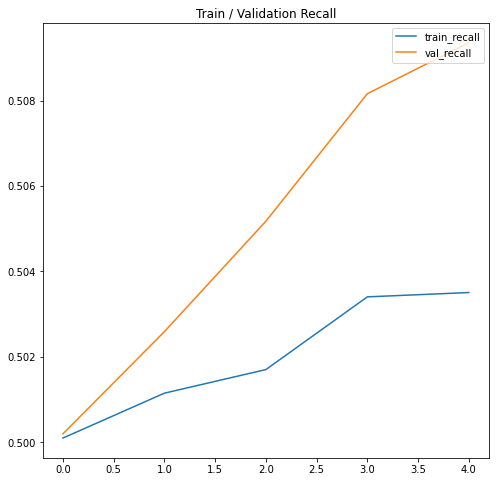

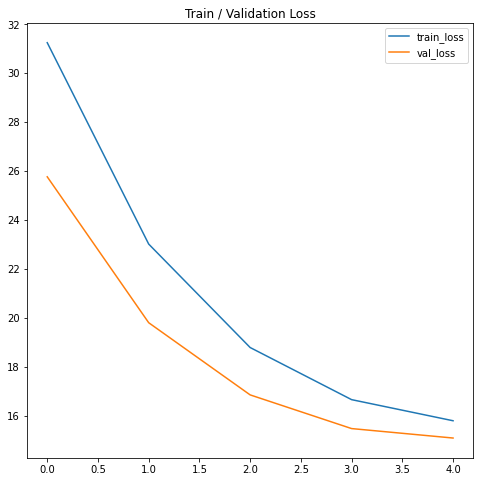

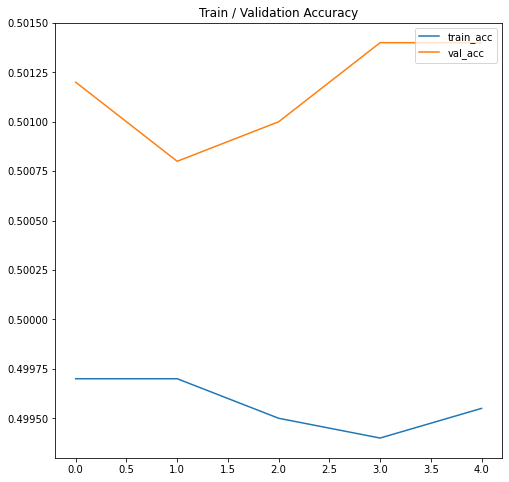

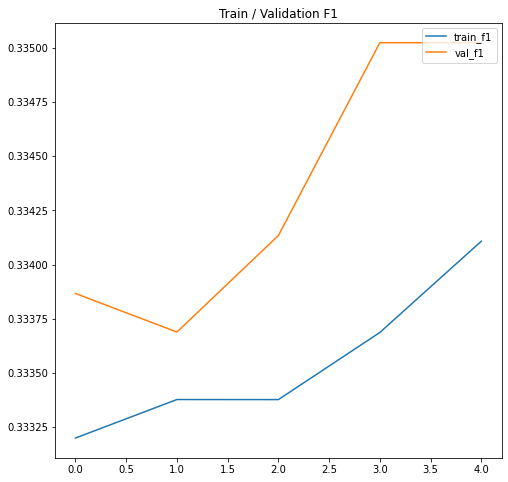

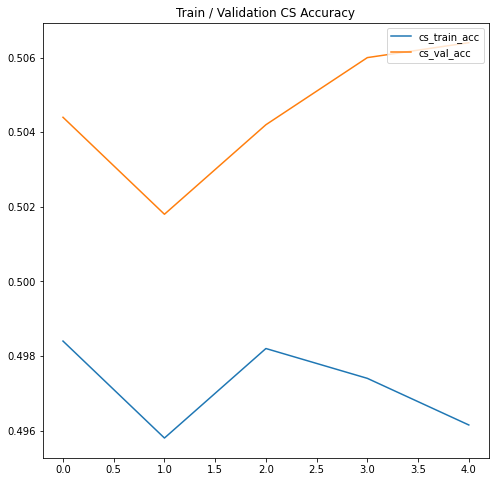

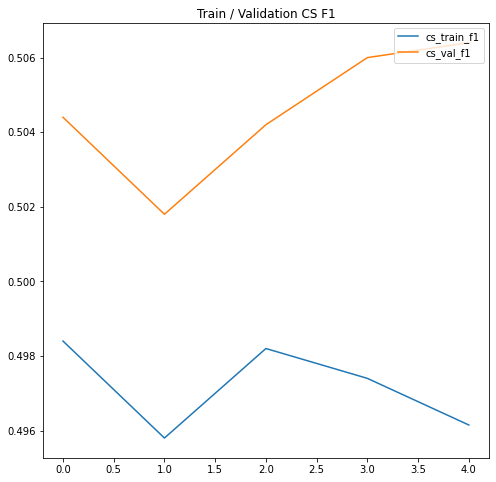

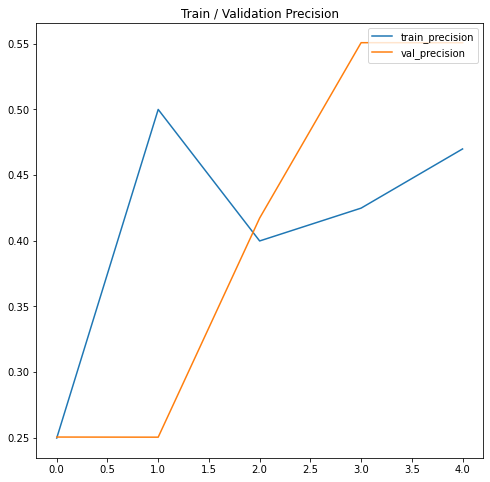

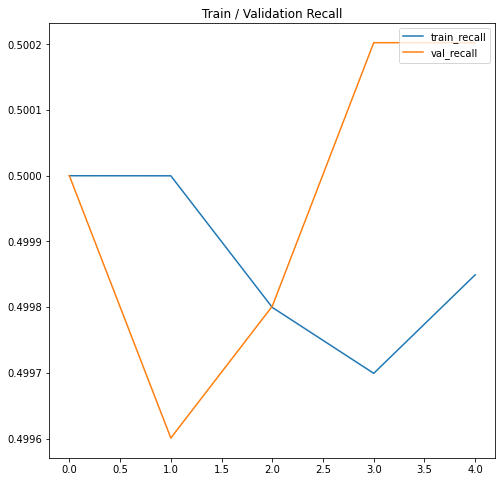

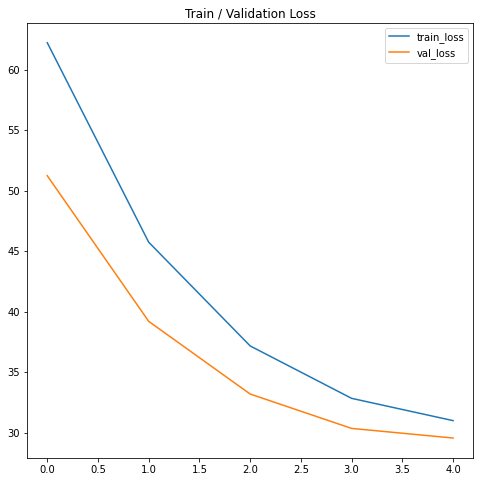

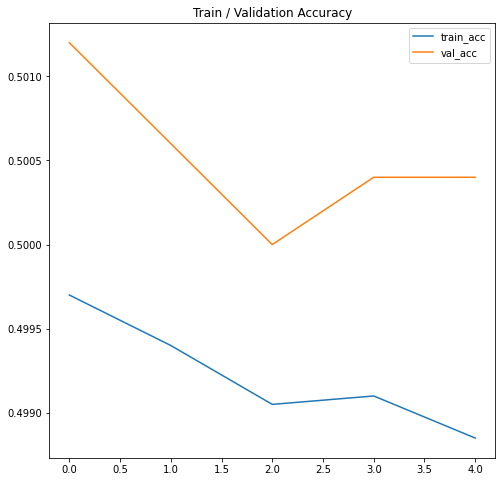

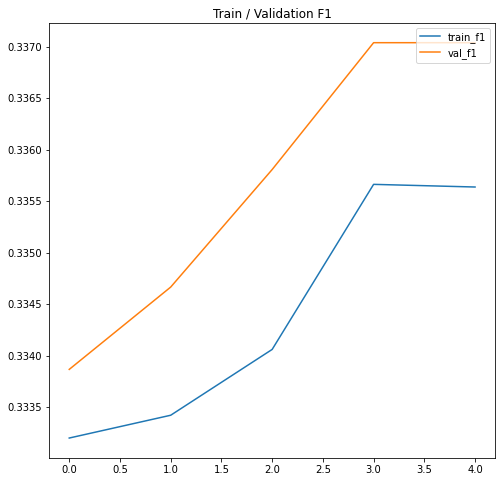

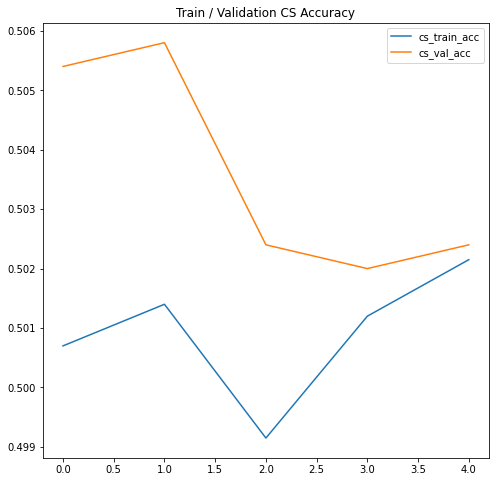

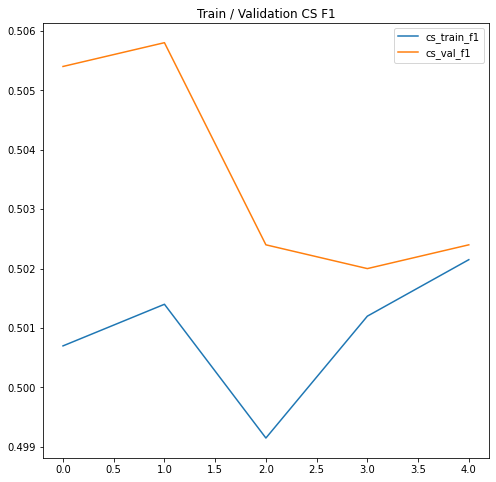

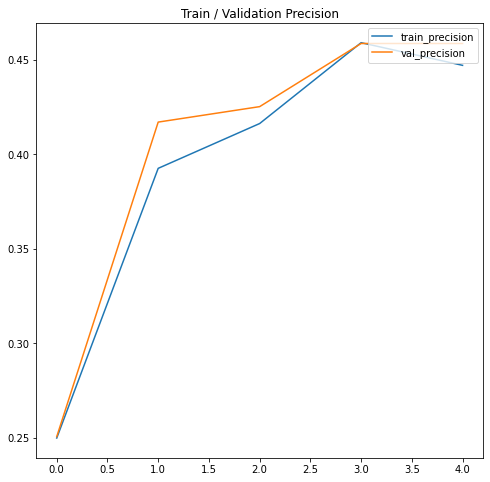

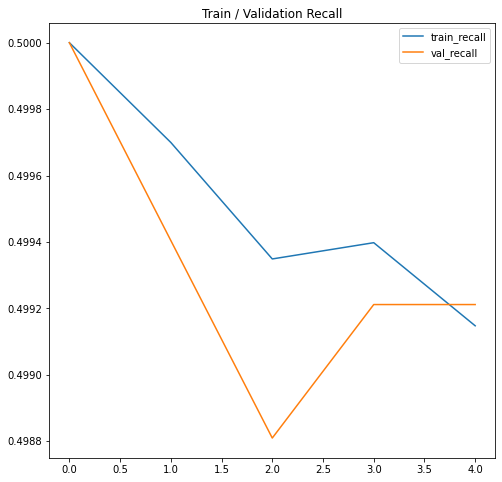

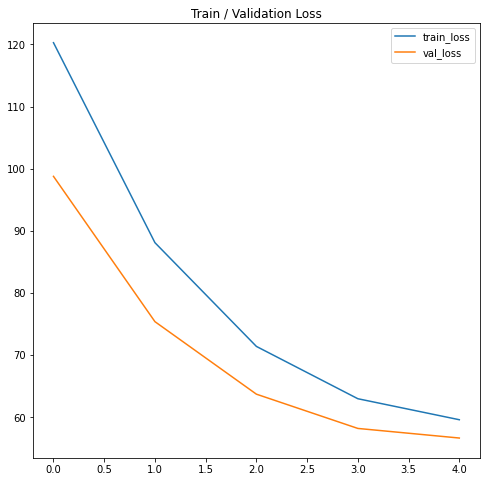

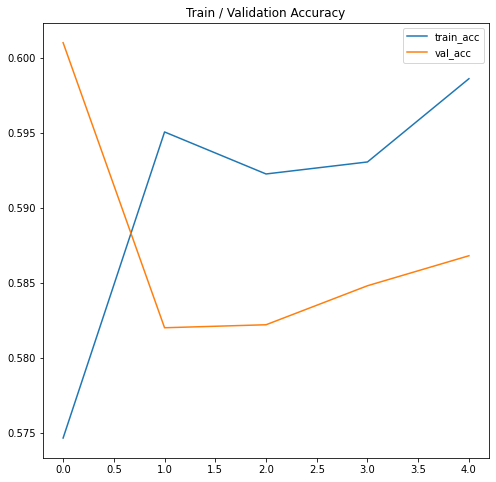

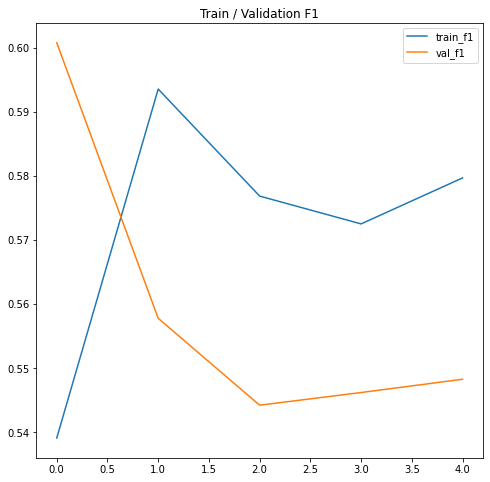

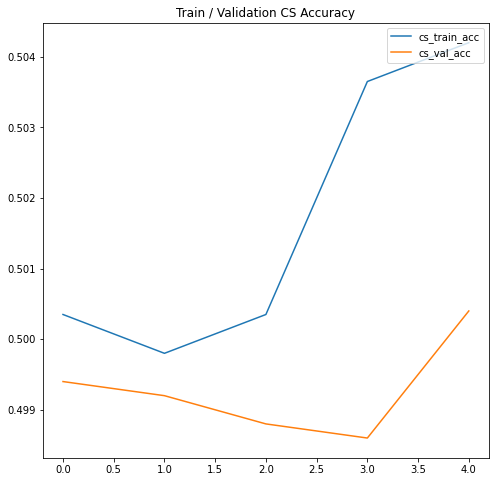

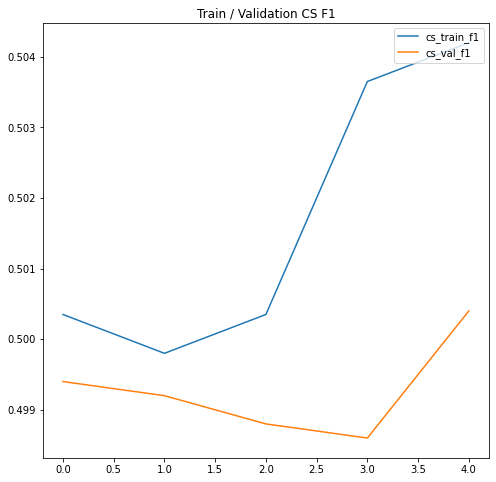

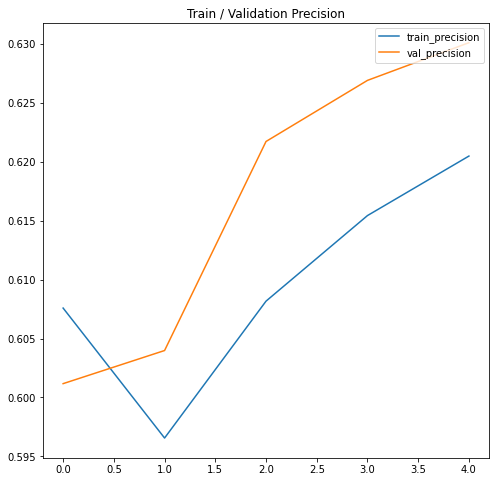

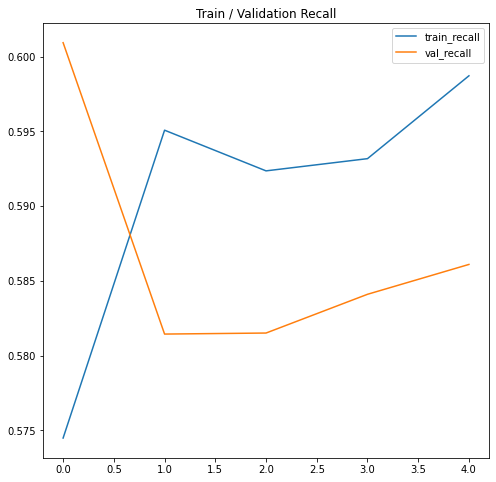

In [6]:
for lat in latents:
    print('Latents:', lat)
    train_wrapper(device_id=0, train_base=False, train_space=True, experiment_name='inter-loss', n_latent=lat, config={
        'l1': 0.5,
        'l2': 1e-2,
        'ce_w': 1.0,
    })()

In [7]:
for lat in latents:
    print('Latents:', lat)
    train_wrapper(device_id=0, train_base=False, train_space=True, experiment_name='inter-loss', n_latent=lat, config={
        'l1': 0,
        'l2': 0,
        'ce_w': 1.0,
    })()

2024-06-16 15:55:14,498 - default.terminal - INFO - Starting...
2024-06-16 15:55:14,500 - default.terminal - INFO - Config: {'experiment_name': 'inter-loss', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'distilbert-base-cased', 'num_labels': 2, 'num_epochs': 5, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 256, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 4, 'l1': 0, 'l2': 0, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x7a918879ed30>, 'get_data_func': <function prepare_dataset at 0x7a918879e940>}
2024-06-16 15:55:14,500 - default.terminal - DEBUG - Loading dataset...


Latents: 4


2024-06-16 15:55:16,077 - default.terminal - DEBUG - Training space model...
2024-06-16 15:55:16,170 - default.terminal - INFO - Number of space model parameters: 6162
2024-06-16 15:55:16,179 - default.terminal - DEBUG - Inter-space loss: 0.0
2024-06-16 15:55:16,180 - default.terminal - DEBUG - Intra-space loss: 0.0
2024-06-16 15:55:16,180 - default.terminal - INFO - ****************************** Iteration: 1 ******************************
2024-06-16 15:55:16,182 - default.terminal - DEBUG - Train steps: 390
2024-06-16 15:55:16,182 - default.terminal - DEBUG - Steps per epoch: 78.125
2024-06-16 15:55:16,183 - default.terminal - INFO - Epoch: 1
100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]
2024-06-16 15:57:28,357 - default.terminal - INFO - 
2024-06-16 15:57:28,358 - default.terminal - INFO - Train loss: 0.6947739380824415 | Val loss: 0.6921663761138916
2024-06-16 15:57:28,358 - default.terminal - INFO - Train acc: 0.50105 | Val acc: 0.5048
2024-06-16

Initial GPU Usage
GPU memory occupied: 19485 MB.
GPU Usage after emptying the cache
GPU memory occupied: 10649 MB.


2024-06-16 16:08:26,441 - default.terminal - DEBUG - Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [02:06<00:00,  1.29s/it]
2024-06-16 16:10:32,620 - default.terminal - INFO - Val loss: 0.6842054511819567
2024-06-16 16:10:32,620 - default.terminal - INFO - Val acc: 0.6582
2024-06-16 16:10:32,621 - default.terminal - INFO - CS Val acc: 0.5
2024-06-16 16:10:32,622 - default.terminal - INFO - Val f1: 0.6300426278695334
2024-06-16 16:10:32,622 - default.terminal - INFO - CS Val f1: 0.3333333333333333
2024-06-16 16:10:32,623 - default.terminal - INFO - Val precision: 0.7274423410719872
2024-06-16 16:10:32,623 - default.terminal - INFO - Val recall: 0.6582
2024-06-16 16:10:32,634 - default.terminal - INFO - Starting...
2024-06-16 16:10:32,635 - default.terminal - INFO - Config: {'experiment_name': 'inter-loss', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'distil

Latents: 8


2024-06-16 16:10:34,195 - default.terminal - DEBUG - Training space model...
2024-06-16 16:10:34,292 - default.terminal - INFO - Number of space model parameters: 12322
2024-06-16 16:10:34,300 - default.terminal - DEBUG - Inter-space loss: 0.0
2024-06-16 16:10:34,301 - default.terminal - DEBUG - Intra-space loss: 0.0
2024-06-16 16:10:34,301 - default.terminal - INFO - ****************************** Iteration: 1 ******************************
2024-06-16 16:10:34,303 - default.terminal - DEBUG - Train steps: 390
2024-06-16 16:10:34,303 - default.terminal - DEBUG - Steps per epoch: 78.125
2024-06-16 16:10:34,304 - default.terminal - INFO - Epoch: 1
100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]
2024-06-16 16:12:46,858 - default.terminal - INFO - 
2024-06-16 16:12:46,859 - default.terminal - INFO - Train loss: 0.6925121251540848 | Val loss: 0.6890172779560089
2024-06-16 16:12:46,860 - default.terminal - INFO - Train acc: 0.51435 | Val acc: 0.5588
2024-06-1

Initial GPU Usage
GPU memory occupied: 19869 MB.
GPU Usage after emptying the cache
GPU memory occupied: 10649 MB.


2024-06-16 16:23:45,017 - default.terminal - DEBUG - Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [02:06<00:00,  1.29s/it]
2024-06-16 16:25:51,203 - default.terminal - INFO - Val loss: 0.6765767506190709
2024-06-16 16:25:51,204 - default.terminal - INFO - Val acc: 0.71836
2024-06-16 16:25:51,205 - default.terminal - INFO - CS Val acc: 0.5
2024-06-16 16:25:51,206 - default.terminal - INFO - Val f1: 0.7102959172046814
2024-06-16 16:25:51,207 - default.terminal - INFO - CS Val f1: 0.3333333333333333
2024-06-16 16:25:51,207 - default.terminal - INFO - Val precision: 0.7457189201404346
2024-06-16 16:25:51,208 - default.terminal - INFO - Val recall: 0.71836
2024-06-16 16:25:51,219 - default.terminal - INFO - Starting...
2024-06-16 16:25:51,220 - default.terminal - INFO - Config: {'experiment_name': 'inter-loss', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'dist

Latents: 16


2024-06-16 16:25:52,790 - default.terminal - DEBUG - Training space model...
2024-06-16 16:25:52,884 - default.terminal - INFO - Number of space model parameters: 24642
2024-06-16 16:25:52,892 - default.terminal - DEBUG - Inter-space loss: 0.0
2024-06-16 16:25:52,893 - default.terminal - DEBUG - Intra-space loss: 0.0
2024-06-16 16:25:52,894 - default.terminal - INFO - ****************************** Iteration: 1 ******************************
2024-06-16 16:25:52,895 - default.terminal - DEBUG - Train steps: 390
2024-06-16 16:25:52,895 - default.terminal - DEBUG - Steps per epoch: 78.125
2024-06-16 16:25:52,896 - default.terminal - INFO - Epoch: 1
100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]
2024-06-16 16:28:05,470 - default.terminal - INFO - 
2024-06-16 16:28:05,471 - default.terminal - INFO - Train loss: 0.687324280225778 | Val loss: 0.6803068786859512
2024-06-16 16:28:05,472 - default.terminal - INFO - Train acc: 0.57875 | Val acc: 0.6794
2024-06-16

Initial GPU Usage
GPU memory occupied: 19869 MB.
GPU Usage after emptying the cache
GPU memory occupied: 10649 MB.


/home/stepan/cam-explain/train.py:231: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 8))
2024-06-16 16:39:03,114 - default.terminal - DEBUG - Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [02:05<00:00,  1.29s/it]
2024-06-16 16:41:09,136 - default.terminal - INFO - Val loss: 0.6581882658053417
2024-06-16 16:41:09,137 - default.terminal - INFO - Val acc: 0.77888
2024-06-16 16:41:09,138 - default.terminal - INFO - CS Val acc: 0.49052
2024-06-16 16:41:09,139 - default.terminal - INFO - Val f1: 0.7782637065006259
2024-06-16 16:41:09,139 - default.terminal - INFO - CS Val f1: 0.3757633739562959
2024-06-16 16:41:09,140 - default.terminal - INFO - Va

Latents: 32


2024-06-16 16:41:10,705 - default.terminal - DEBUG - Training space model...
2024-06-16 16:41:10,802 - default.terminal - INFO - Number of space model parameters: 49282
2024-06-16 16:41:10,810 - default.terminal - DEBUG - Inter-space loss: 0.0
2024-06-16 16:41:10,811 - default.terminal - DEBUG - Intra-space loss: 0.0
2024-06-16 16:41:10,811 - default.terminal - INFO - ****************************** Iteration: 1 ******************************
2024-06-16 16:41:10,813 - default.terminal - DEBUG - Train steps: 390
2024-06-16 16:41:10,813 - default.terminal - DEBUG - Steps per epoch: 78.125
2024-06-16 16:41:10,814 - default.terminal - INFO - Epoch: 1
100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]
2024-06-16 16:43:23,533 - default.terminal - INFO - 
2024-06-16 16:43:23,534 - default.terminal - INFO - Train loss: 0.6836259251908411 | Val loss: 0.6747817367315292
2024-06-16 16:43:23,534 - default.terminal - INFO - Train acc: 0.5977 | Val acc: 0.699
2024-06-16 